In [18]:
import tensorflow as tf
import keras_cv
import numpy as np
import copy
from joblib import load
import pandas as pd
import copy

import librosa.display
import matplotlib.pyplot as plt

import librosa
import albumentations as A

from joblib import Parallel, delayed

from tqdm import tqdm

import os, gc

from scipy import signal as sci_signal
from torchvision.models import efficientnet

import albumentations as albu
import random

import keras
from sklearn.model_selection import train_test_split
import cv2
from joblib import load, dump

image = 256

In [3]:
x, y = load('/kaggle/input/birdclef-2023/BirdCLEF_2023_training.joblib')
print(x.shape, y.shape)

(64, 256, 256, 1) (64, 264)


In [19]:
class TrainDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, x_data = x, y_data = y, batch_size=32, 
                     shuffle=False, mode= 'train', image_shape = image ):
        
        self.image_shape = image_shape
        self.x_data = x_data
        self.y_data = y_data
            
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.mode = mode
        
        self.transform =  albu.Compose([
                albu.HorizontalFlip(0.3),
                albu.XYMasking(    
                        p=0.4,
                        num_masks_x=(1, 3),
                        num_masks_y=(1, 3),
                        mask_x_length=(1, 10),
                        mask_y_length=(1, 20),
                        ),
                 albu.RandomBrightnessContrast(p=0.4),
                ])
        self.indices = np.arange(len(self.x_data))
        
        if self.shuffle:
            np.random.shuffle(self.indices)
    
    def __len__(self):
        return int(np.ceil(len(self.x_data) / self.batch_size))
    
    def aug(self, x, y):
        x = np.transpose(x.reshape(-1,self.image_shape,self.image_shape), axes=[1, 2, 0])
        x = self.transform(image = x, p = 0.3)['image']
        x = np.transpose(x, axes=[2, 0, 1])
        
        x = x.reshape(-1,self.image_shape,self.image_shape,1)
        x = tf.keras.layers.GaussianNoise(stddev = 0.006)(x, training = True).numpy()
        return x, y
    
    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        x_batch = self.x_data[batch_indices]
        y_batch = self.y_data[batch_indices]
        
        if self.mode =='aug':
            x_batch, y_batch = self.aug(x_batch, y_batch)
            
        x_batch = x_batch.reshape(-1,self.image_shape,self.image_shape,1)
        
        return x_batch, y_batch    
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

(32, 256, 256, 1) (32, 264)


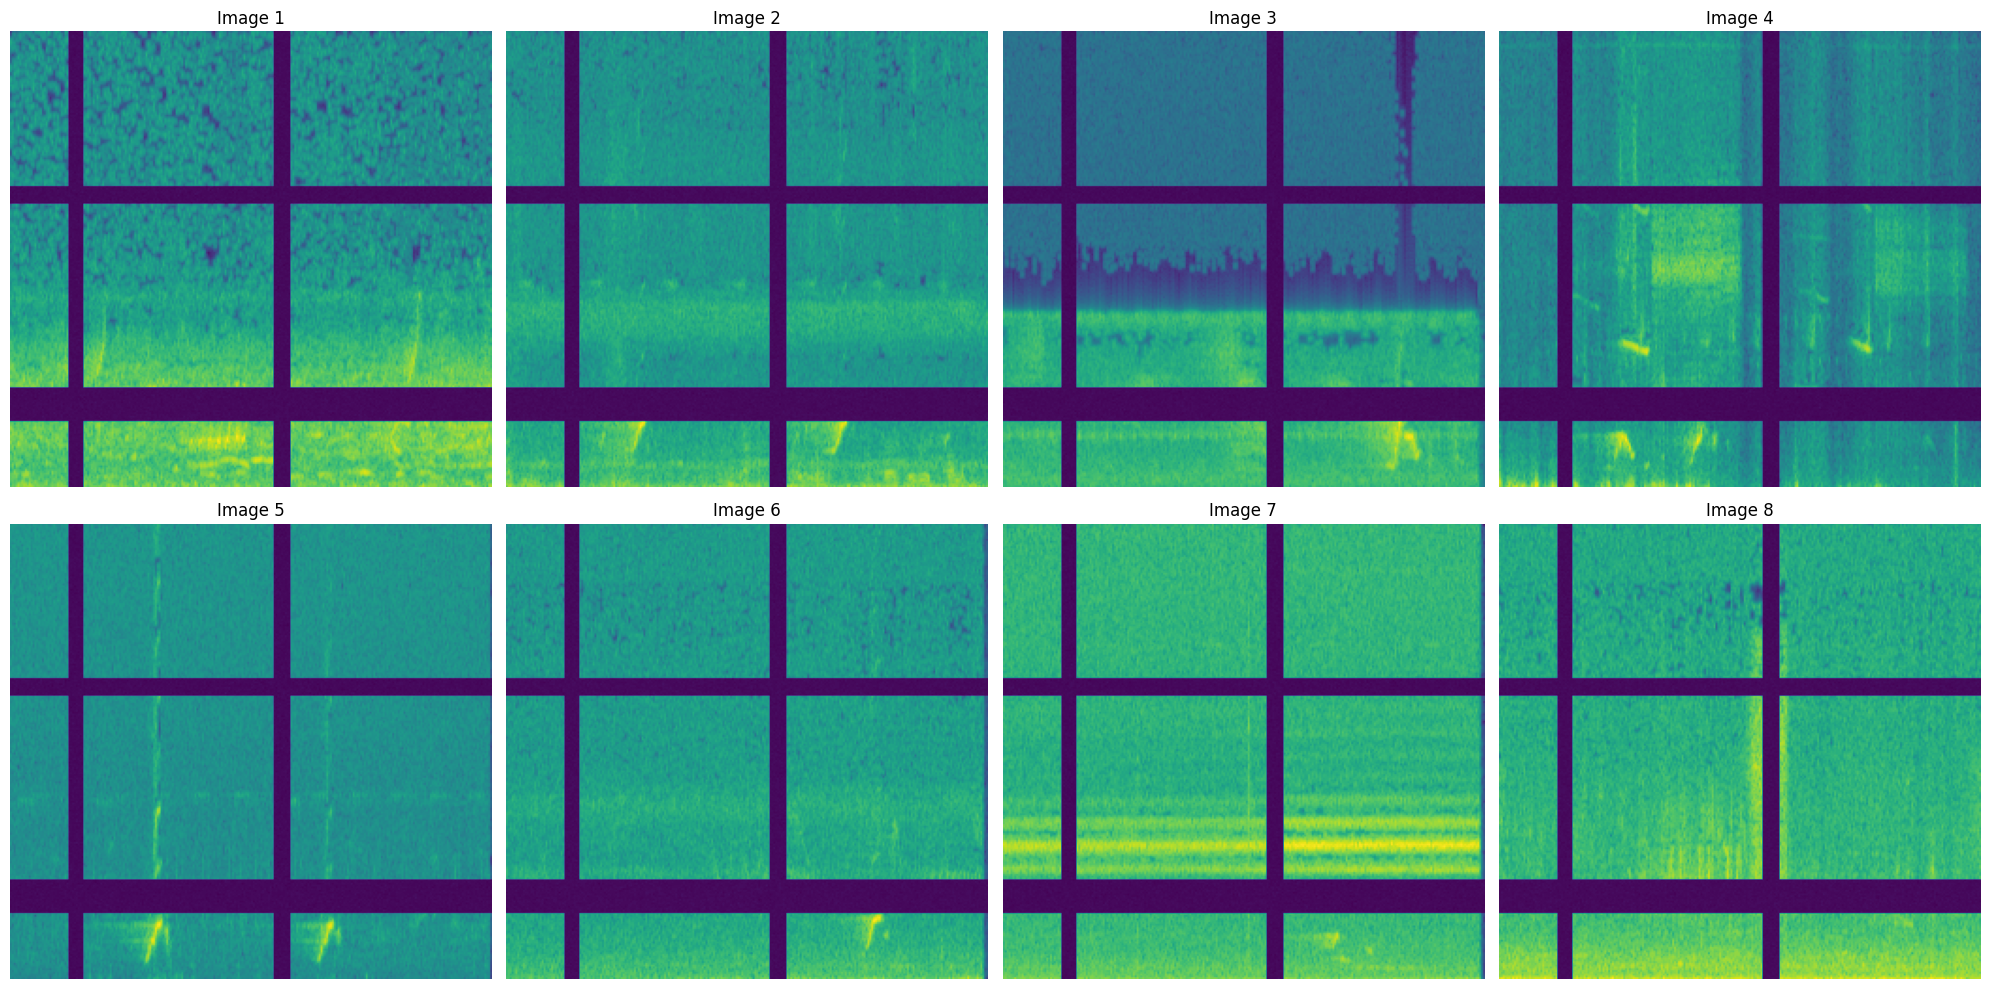

CPU times: user 2.35 s, sys: 160 ms, total: 2.51 s
Wall time: 2.17 s


In [20]:
%%time
train_gen = TrainDataGenerator(batch_size=32, shuffle = True, mode = 'aug',
                              x_data = x, y_data= y)
for x_batch, y_batch in (train_gen):
    print(x_batch.shape, y_batch.shape)
    
    fig, axs = plt.subplots(2, 4, figsize=(20, 10))

    for i, im in enumerate(x_batch[0:8]):
        ax = axs[i // 4, i % 4]
        ax.imshow(im, aspect='auto', origin='lower', cmap='viridis')
        ax.set_title(f'Image {i+1}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()
    break

# Model

In [21]:
opt = tf.keras.optimizers.Adam(learning_rate = 1e-3)
metrics = [tf.keras.metrics.AUC()]

def build_model():
    
    inp = tf.keras.Input(shape=(image,image,1))
    
    base_model = tf.keras.applications.EfficientNetB0(
        include_top=False,
        weights='imagenet',
    )

    x = inp
    x = tf.keras.layers.Concatenate(axis=3)([x,x,x])
    
    # OUTPUT
    x = base_model(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    x = tf.keras.layers.Dense(264,activation='softmax', dtype='float32')(x)
        
    model = tf.keras.Model(inputs=inp, outputs=x)
    loss = keras.losses.CategoricalFocalCrossentropy()

    model.compile(loss=loss, optimizer = opt, metrics= metrics)
    return model

model = build_model()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


# Lr Scheduler

In [22]:
def lrfn(epoch):
    minimum = 1e-6
    i = 1e-3
    decay = 5e-1
    return minimum + i*(decay**epoch)

LR = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

In [23]:
train_gen = TrainDataGenerator( batch_size=32, shuffle = True, mode = 'aug' )
valid_gen = TrainDataGenerator( batch_size=32, shuffle = True, mode = 'test')

# Training

In [26]:
model.fit(train_gen, epochs=2, validation_data = valid_gen, callbacks=[LR])


Epoch 1: LearningRateScheduler setting learning rate to 0.001001.
Epoch 1/2
2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 9s/step - auc_1: 0.9879 - loss: 0.7085 - val_auc_1: 0.5000 - val_loss: 1.3757 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.000501.
Epoch 2/2
2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 9s/step - auc_1: 0.9996 - loss: 0.2607 - val_auc_1: 0.5000 - val_loss: 1.3463 - learning_rate: 5.0100e-04


# Save Weights

In [27]:
model.save_weights('Trained_weights.weights.h5')